# Extension
We make the code work with Pytorch Lightning and compare different AI algorithms

### 1. Import Packages

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
from pandas_datareader import data
import datetime
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas_datareader.data as pdr

from scipy.optimize import minimize

import pytorch_lightning as pl
import sys; sys.path.append('../')
from src.lightning_utils import LitTimeSeriesModule

# Disable warnings
import warnings
import logging
warnings.filterwarnings('ignore')
my_logger = logging.getLogger("lightning")
my_logger.setLevel(logging.CRITICAL)


### 2. Setting Tickers and Functions

We add stocks from [US News top reccomendations](https://money.usnews.com/investing/stock-market-news/slideshows/best-stocks-to-buy-this-year?slide=12) and see what we can achieve investing in them

In [2]:
tickers = ['ADBE', 'SPOT', 'BJ', 'DIS', 'FB', 'BABA', 'LOW', 'NLS', 'SONO', 'NEM']


# Data loading
start = (2010, 1, 1) 
start_time = datetime.datetime(*start)  
end = (2020, 12, 31) 
end_time = datetime.datetime(*end) 

In [3]:
# Setting Device - If you have gpu, you can change the device 'gpu'
device = torch.device('cpu')

In [4]:
def MAE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred)))

def MSE(y_true, y_pred):
    return np.mean(np.square((y_true - y_pred)))

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred))))

def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MPE(y_true, y_pred): 
    return np.mean((y_true - y_pred) / y_true) * 100

### 3. Setting Hyperparameters and Training Data

In [5]:
# We set a lower number of epochs for avoiding overfitting along with higher learning rate
num_epochs = 1000
learning_rate = 0.001

input_size = 6 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked LSTM layers

num_classes = 1 #number of output classes 
# tickers = ['AAPL', 'ADBE', 'AMZN'] #########################TEST

df_results_rnn = pd.DataFrame()
df_metrics_rnn = pd.DataFrame()
df_results_gru = pd.DataFrame()
df_metrics_gru = pd.DataFrame()
df_results_lstm = pd.DataFrame()
df_metrics_lstm = pd.DataFrame()

results = [df_results_rnn, df_results_gru, df_results_lstm]
metrics = [df_metrics_rnn, df_metrics_gru, df_metrics_lstm]
experiments = ['RNN', 'GRU', 'LSTM']

In [6]:

for i in range(len(tickers)):
#     df = pd.read_csv('./stock_price_data/' + tickers[i]+'.csv', index_col = 0)
    df = pdr.DataReader(tickers[i], 'yahoo', start_time, end_time)
    X = df # Using high price, low price, Open price, Close price, Volume, and Adjusted Close Price to predict adjusted close price
    y = df.iloc[:, 5:6] #Predicting adjusted close price

    MMS = MinMaxScaler()

    X_data = MMS.fit_transform(X)
    y_data = MMS.fit_transform(y) 

    train_pct = 0.8
    split = int(train_pct * len(X))
    # Input Variables (6 variables)
    X_train, X_test, y_train, y_test = X_data[:split, :], X_data[split+1:-1 :], y_data[1:split+1, :], y_data[split+2:, :] 
    #We trained 2000 - 2018 data including high price, low price, open price, close price, volume, and adj close data

    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test))

    X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
    X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

    train_dataset = TensorDataset(X_train_tensors_final, y_train_tensors)
    train_dataloader = DataLoader(train_dataset, num_workers=12, batch_size=4096)
    seq_length = X_train_tensors_final.shape[1]
    print(20*'-')
    print('Currently training on: ', tickers[i])

    for exp, e in zip(experiments, range(len(experiments))):
        print('Training ', exp, ' model...')
        net = LitTimeSeriesModule(exp, num_classes, input_size,  hidden_size, num_layers, seq_length, lr=1e-2, weight_decay=0)
        trainer = pl.Trainer(max_epochs=num_epochs, weights_summary=None)
        trainer.fit(net, train_dataloader)

        X_data = MMS.fit_transform(X_test)
        y_data = MMS.fit_transform(y_test) 

        df_X = Variable(torch.Tensor(X_data))
        df_y = Variable(torch.Tensor(y_data))

        df_X = torch.reshape(df_X, (df_X.shape[0], 1, df_X.shape[1]))
        train_predict = net(df_X.to(device))#forward pass
        y_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
        y_true = df_y.data.numpy()

        y_predict = MMS.inverse_transform(y_predict) #reverse transformation
        y_true = MMS.inverse_transform(y_true)
        metrics_value = pd.DataFrame([MAE(y_true, y_predict), MSE(y_true, y_predict), RMSE(y_true, y_predict), MAPE(y_true, y_predict), MPE(y_true, y_predict)])
        metrics_value.columns = [tickers[i]]
        metrics_value.index = ['MAE', 'MSE', 'RMSE', 'MAPE', 'MPE']
        metrics[e] = pd.concat([metrics[e], metrics_value], axis = 1)
        df_results_temp = pd.DataFrame(y_predict)
        df_results_temp.columns = [tickers[i]]
        results[e] = pd.concat([results[e], df_results_temp], axis=1)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


--------------------
Currently training on:  ADBE
Training  RNN  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Training  GRU  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Training  LSTM  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


--------------------
Currently training on:  SPOT
Training  RNN  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Training  GRU  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Training  LSTM  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


--------------------
Currently training on:  BJ
Training  RNN  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Training  GRU  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Training  LSTM  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


--------------------
Currently training on:  DIS
Training  RNN  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Training  GRU  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Training  LSTM  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


--------------------
Currently training on:  FB
Training  RNN  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Training  GRU  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Training  LSTM  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


--------------------
Currently training on:  BABA
Training  RNN  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Training  GRU  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Training  LSTM  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


--------------------
Currently training on:  LOW
Training  RNN  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Training  GRU  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Training  LSTM  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


--------------------
Currently training on:  NLS
Training  RNN  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Training  GRU  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Training  LSTM  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


--------------------
Currently training on:  SONO
Training  RNN  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Training  GRU  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Training  LSTM  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


--------------------
Currently training on:  NEM
Training  RNN  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Training  GRU  model...


Training: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Training  LSTM  model...


Training: 0it [00:00, ?it/s]

### 4-1. Saving Metrics

In [7]:
for exp, i in zip(experiments, range(len(experiments))):
    metrics[i].to_csv('Results of Error Metrics'+exp+'.csv', encoding = 'utf-8-sig')

### 4-2. Building Datasets

In [8]:
for exp, i in zip(experiments, range(len(experiments))):
    results[i].index = df.iloc[len(df) - len(results[i]):, ].index

In [9]:
print(results[1])

                ADBE      SPOT        BJ       DIS        FB      BABA  \
Date                                                                     
2018-10-23  0.433996  0.501977  0.641098  0.592535  0.566695  0.416795   
2018-10-24  0.434744  0.563512  0.651837  0.583776  0.567222  0.427786   
2018-10-25  0.430929  0.599950  0.663737  0.557624  0.563196  0.432651   
2018-10-26  0.430740  0.621478  0.707999  0.559649  0.573005  0.431329   
2018-10-29  0.429336  0.651295  0.697758  0.556991  0.581628  0.412579   
...              ...       ...       ...       ...       ...       ...   
2020-12-24  0.787722       NaN       NaN  0.844998       NaN       NaN   
2020-12-28  0.786919       NaN       NaN  0.844105       NaN       NaN   
2020-12-29  0.788719       NaN       NaN  0.849590       NaN       NaN   
2020-12-30  0.789827       NaN       NaN  0.851507       NaN       NaN   
2020-12-31  0.787987       NaN       NaN  0.851678       NaN       NaN   

                 LOW       NLS      S

In [10]:
df_original = pd.DataFrame()

for i in range(len(tickers)):
#     df = pd.read_csv('./stock_price_data/' + tickers[i]+'.csv', index_col = 0)
    df = pdr.DataReader(tickers[i], 'yahoo', start_time, end_time)
    close = df['Adj Close']
    df_close = pd.DataFrame(close)
    df_close.columns = [tickers[i]]
    df_original = pd.concat([df_original, df_close], axis=1)

ret_daily_original = df_original.iloc[len(df) - len(results[0]) - 251:, ]
ret_daily_original = ret_daily_original.pct_change()
ret_daily_original = ret_daily_original.iloc[1:, ]

n_assets = len(tickers)

ret_daily = []
for exp, i in zip(experiments, range(len(experiments))):
    rd = results[i].pct_change()
    ret_daily.append(rd.iloc[1:, ])

### 5-1. Portfolio Optimization with Stock Price Prediction Results

In [11]:
def obj_sharpe(weights, returns, covmat, rf):
    ret = np.dot(weights, returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(covmat, weights)))
    return 1/((ret-rf)/np.sqrt(vol)) # 1/Sharpe Ratio -> Maximize Sharpe Ratio Using Minimize Function

In [12]:
portfolios = [[]*len(experiments) for _ in range(len(experiments))] # list of lists

for exp, e in zip(experiments, range(len(experiments))):
    for i in range(0, len(ret_daily[e])-1):
        ret_annual = pd.concat([ret_daily_original[i:i+251], ret_daily[e][i:i+1]]).mean() * 252
        cov_annual = pd.concat([ret_daily_original[i:i+251], ret_daily[e][i:i+1]]).cov() * 252
        rf = 0.01
        w0 = np.ones([n_assets])/n_assets
        bnds = tuple((0., 1.) for i in range(n_assets))
        cons = ({'type': 'eq', 'fun': lambda w:  np.sum(w) - 1}) 
        res = minimize(obj_sharpe, w0, (ret_annual, cov_annual, rf), method='SLSQP', bounds=bnds, constraints=cons)
        profit = (ret_daily_original.iloc[i+252] * res.x).sum()
        portfolios[e].append(profit)

In [13]:
portfolios_final = [[]*len(experiments) for _ in range(len(experiments))] # list of lists
std_portfolios = [[]*len(experiments) for _ in range(len(experiments))] # list of lists
Sharpe_ratios = [[]*len(experiments) for _ in range(len(experiments))] # list of lists

for exp, e in zip(experiments, range(len(experiments))):
    portfolios[e] = pd.DataFrame(portfolios[e]) - 0.0003 # Upper bound of security transaction tax
    portfolios[e].index = ret_daily[e].index[1:]
    portfolios[e].columns = ['Portfolio Return']

    data = pd.DataFrame([['2018-10-24',0]], columns=['Date','Portfolio Return'])
    data.index = data['Date']
    data = data.drop(['Date'], axis=1)

    portfolios[e] = pd.concat([data, portfolios[e]])

    c_return = []

    for i in range(0, len(portfolios[e])):
        if i == 0:
            c_return_v_init = 0
            c_return.append(c_return_v_init)
        else:
            c_return_v = (c_return[i-1] + 1) * (portfolios[e]['Portfolio Return'][i] + 1) - 1
            c_return.append(c_return_v)
    c_return = pd.DataFrame(c_return)
    c_return.index = portfolios[e].index

    portfolios_final[e] = pd.concat([portfolios[e], c_return], axis = 1)
    portfolios_final[e].columns = ['Portfolio Return', 'Cumulative Return']

    risk_free_rate = 0.015
    std_portfolios[e] = portfolios[e]['Portfolio Return'][1:].std()
    Sharpe_ratios[e] = (portfolios_final[e]['Portfolio Return'][1:] - risk_free_rate)/std_portfolios[e]
    Sharpe_ratios[e] = Sharpe_ratios[e].mean()
    print('Sharpe ratio (Portfolio with %s Price Prediction Results): %.2f' % (exp, Sharpe_ratios[e]))

Sharpe ratio (Portfolio with RNN Price Prediction Results): -0.35
Sharpe ratio (Portfolio with GRU Price Prediction Results): -0.34
Sharpe ratio (Portfolio with LSTM Price Prediction Results): -0.34


### 5-2. Equally-Weighted Portfolio

In [14]:
portfolio_eqw = []

for i in range(0, len(ret_daily[0])-1):
    weights = np.ones([n_assets])/n_assets
    profit_eqw = (ret_daily_original.iloc[i+252] * weights).sum()
    portfolio_eqw.append(profit_eqw)

portfolio_eqw = pd.DataFrame(portfolio_eqw) 
portfolio_eqw.index = ret_daily[0].index[1:]
portfolio_eqw.columns = ['Portfolio Return']
    
data_eqw = pd.DataFrame([['2018-10-24',0]], columns=['Date','Portfolio Return'])
data_eqw.index = data_eqw['Date']
data_eqw = data_eqw.drop(['Date'], axis=1)

portfolio_eqw = pd.concat([data_eqw, portfolio_eqw])

c_return_eqw = []

for i in range(0, len(portfolio_eqw)):
    if i == 0:
        c_return_eqw_v_init = 0
        c_return_eqw.append(c_return_eqw_v_init)
    else:
        c_return_eqw_v = (c_return_eqw[i-1] + 1) * (portfolio_eqw['Portfolio Return'][i] + 1) - 1
        c_return_eqw.append(c_return_eqw_v)
        
c_return_eqw = pd.DataFrame(c_return_eqw)
c_return_eqw.index = portfolio_eqw.index

portfolio_eqw_final = pd.concat([portfolio_eqw, c_return_eqw], axis = 1)
portfolio_eqw_final.columns = ['Portfolio Return', 'Cumulative Return']

In [15]:
portfolio_eqw

,Portfolio Return
Date,
2018-10-24,0.000000
2018-10-25 00:00:00,0.016067
2018-10-26 00:00:00,-0.022583
2018-10-29 00:00:00,-0.013782
2018-10-30 00:00:00,0.004561
...,...
2020-12-24 00:00:00,-0.015227
2020-12-28 00:00:00,-0.010328
2020-12-29 00:00:00,-0.004570


In [16]:
risk_free_rate = 0.015
std_portfolio_eqw = portfolio_eqw_final['Portfolio Return'][1:].std()
Sharpe_eqw = (portfolio_eqw_final['Portfolio Return'][1:] - risk_free_rate)/std_portfolio_eqw
Sharpe_eqw = Sharpe_eqw.mean()
print('Sharpe ratio (Equally-Weighted Portfolio): %.2f' % Sharpe_eqw)

Sharpe ratio (Equally-Weighted Portfolio): -0.75


In [17]:
portfolio_eqw_final

,Portfolio Return,Cumulative Return
Date,,
2018-10-24,0.000000,0.000000
2018-10-25 00:00:00,0.016067,0.016067
2018-10-26 00:00:00,-0.022583,-0.006878
2018-10-29 00:00:00,-0.013782,-0.020565
2018-10-30 00:00:00,0.004561,-0.016098
...,...,...
2020-12-24 00:00:00,-0.015227,1.324468
2020-12-28 00:00:00,-0.010328,1.300460
2020-12-29 00:00:00,-0.004570,1.289947


### 5-3. Capitalization Weighted Portfolio

In [18]:
from pandas_datareader import data

market_cap_data = data.get_quote_yahoo(tickers)['marketCap']
market_cap = pd.DataFrame(market_cap_data)

In [19]:
market_cap = market_cap / market_cap.sum()

In [20]:
market_cap = np.array(market_cap['marketCap'].tolist())

In [21]:
portfolio_mcw = []

for i in range(0, len(ret_daily[0])-1):
    weights = market_cap
    profit_mcw = (ret_daily_original.iloc[i+252] * weights).sum()
    portfolio_mcw.append(profit_mcw)

portfolio_mcw = pd.DataFrame(portfolio_mcw) 
portfolio_mcw.index = ret_daily[0].index[1:]
portfolio_mcw.columns = ['Portfolio Return']

data_mcw = pd.DataFrame([['2018-10-24',0]], columns=['Date','Portfolio Return'])
data_mcw.index = data_mcw['Date']
data_mcw = data_mcw.drop(['Date'], axis=1)

portfolio_mcw = pd.concat([data_mcw, portfolio_mcw])

c_return_mcw = []

for i in range(0, len(portfolio_mcw)):
    if i == 0:
        c_return_mcw_v_init = 0
        c_return_mcw.append(c_return_mcw_v_init)
    else:
        c_return_mcw_v = (c_return_mcw[i-1] + 1) * (portfolio_mcw['Portfolio Return'][i] + 1) - 1
        c_return_mcw.append(c_return_mcw_v)
        
c_return_mcw = pd.DataFrame(c_return_mcw)
c_return_mcw.index = portfolio_mcw.index

portfolio_mcw_final = pd.concat([portfolio_mcw, c_return_mcw], axis = 1)
portfolio_mcw_final.columns = ['Portfolio Return', 'Cumulative Return']

In [22]:
risk_free_rate = 0.015
std_portfolio_mcw = portfolio_mcw_final['Portfolio Return'][1:].std()
Sharpe_mcw = (portfolio_mcw_final['Portfolio Return'][1:] - risk_free_rate)/std_portfolio_mcw
Sharpe_mcw = Sharpe_mcw.mean()
print('Sharpe ratio (Market Capitalization-Weighted Portfolio): %.2f' % Sharpe_mcw)

Sharpe ratio (Market Capitalization-Weighted Portfolio): -0.73


In [23]:
portfolio_mcw_final.tail()

,Portfolio Return,Cumulative Return
Date,,
2020-12-24 00:00:00,-0.033638,0.879657
2020-12-28 00:00:00,0.017224,0.912032
2020-12-29 00:00:00,0.014314,0.939401
2020-12-30 00:00:00,-0.002323,0.934895
2020-12-31 00:00:00,-0.004109,0.926944


### 6. Plotting Cumulative Returns of Portfolios

In [24]:
plt.rcParams["figure.figsize"] = (32,18)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 
plt.rcParams.update({'font.size': 50})
plt.rcParams['lines.linewidth'] = 3

In [25]:
for p in portfolios: p.index = pd.to_datetime(p.index)
portfolio_eqw_final.index = pd.to_datetime(portfolio_eqw_final.index)
portfolio_mcw_final.index = pd.to_datetime(portfolio_mcw_final.index)

In [26]:
portfolios[0]

,Portfolio Return
Date,
2018-10-24,0.000000
2018-10-25,0.019325
2018-10-26,-0.024421
2018-10-29,-0.024914
2018-10-30,0.000922
...,...
2020-12-24,-0.012605
2020-12-28,-0.054445
2020-12-29,-0.083380


In [30]:
plt.rcParams["figure.figsize"] = (32,18)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 
plt.rcParams.update({'font.size': 50})
plt.rcParams['lines.linewidth'] = 3

In [33]:
plt.rcParams["figure.figsize"] = (32,18)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 
plt.rcParams.update({'font.size': 50})
plt.rcParams['lines.linewidth'] = 3

In [35]:
# Plot style
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams["figure.dpi"] = 300
plt.rcParams['axes.grid'] = True 
plt.rcParams.update({'font.size': 20})

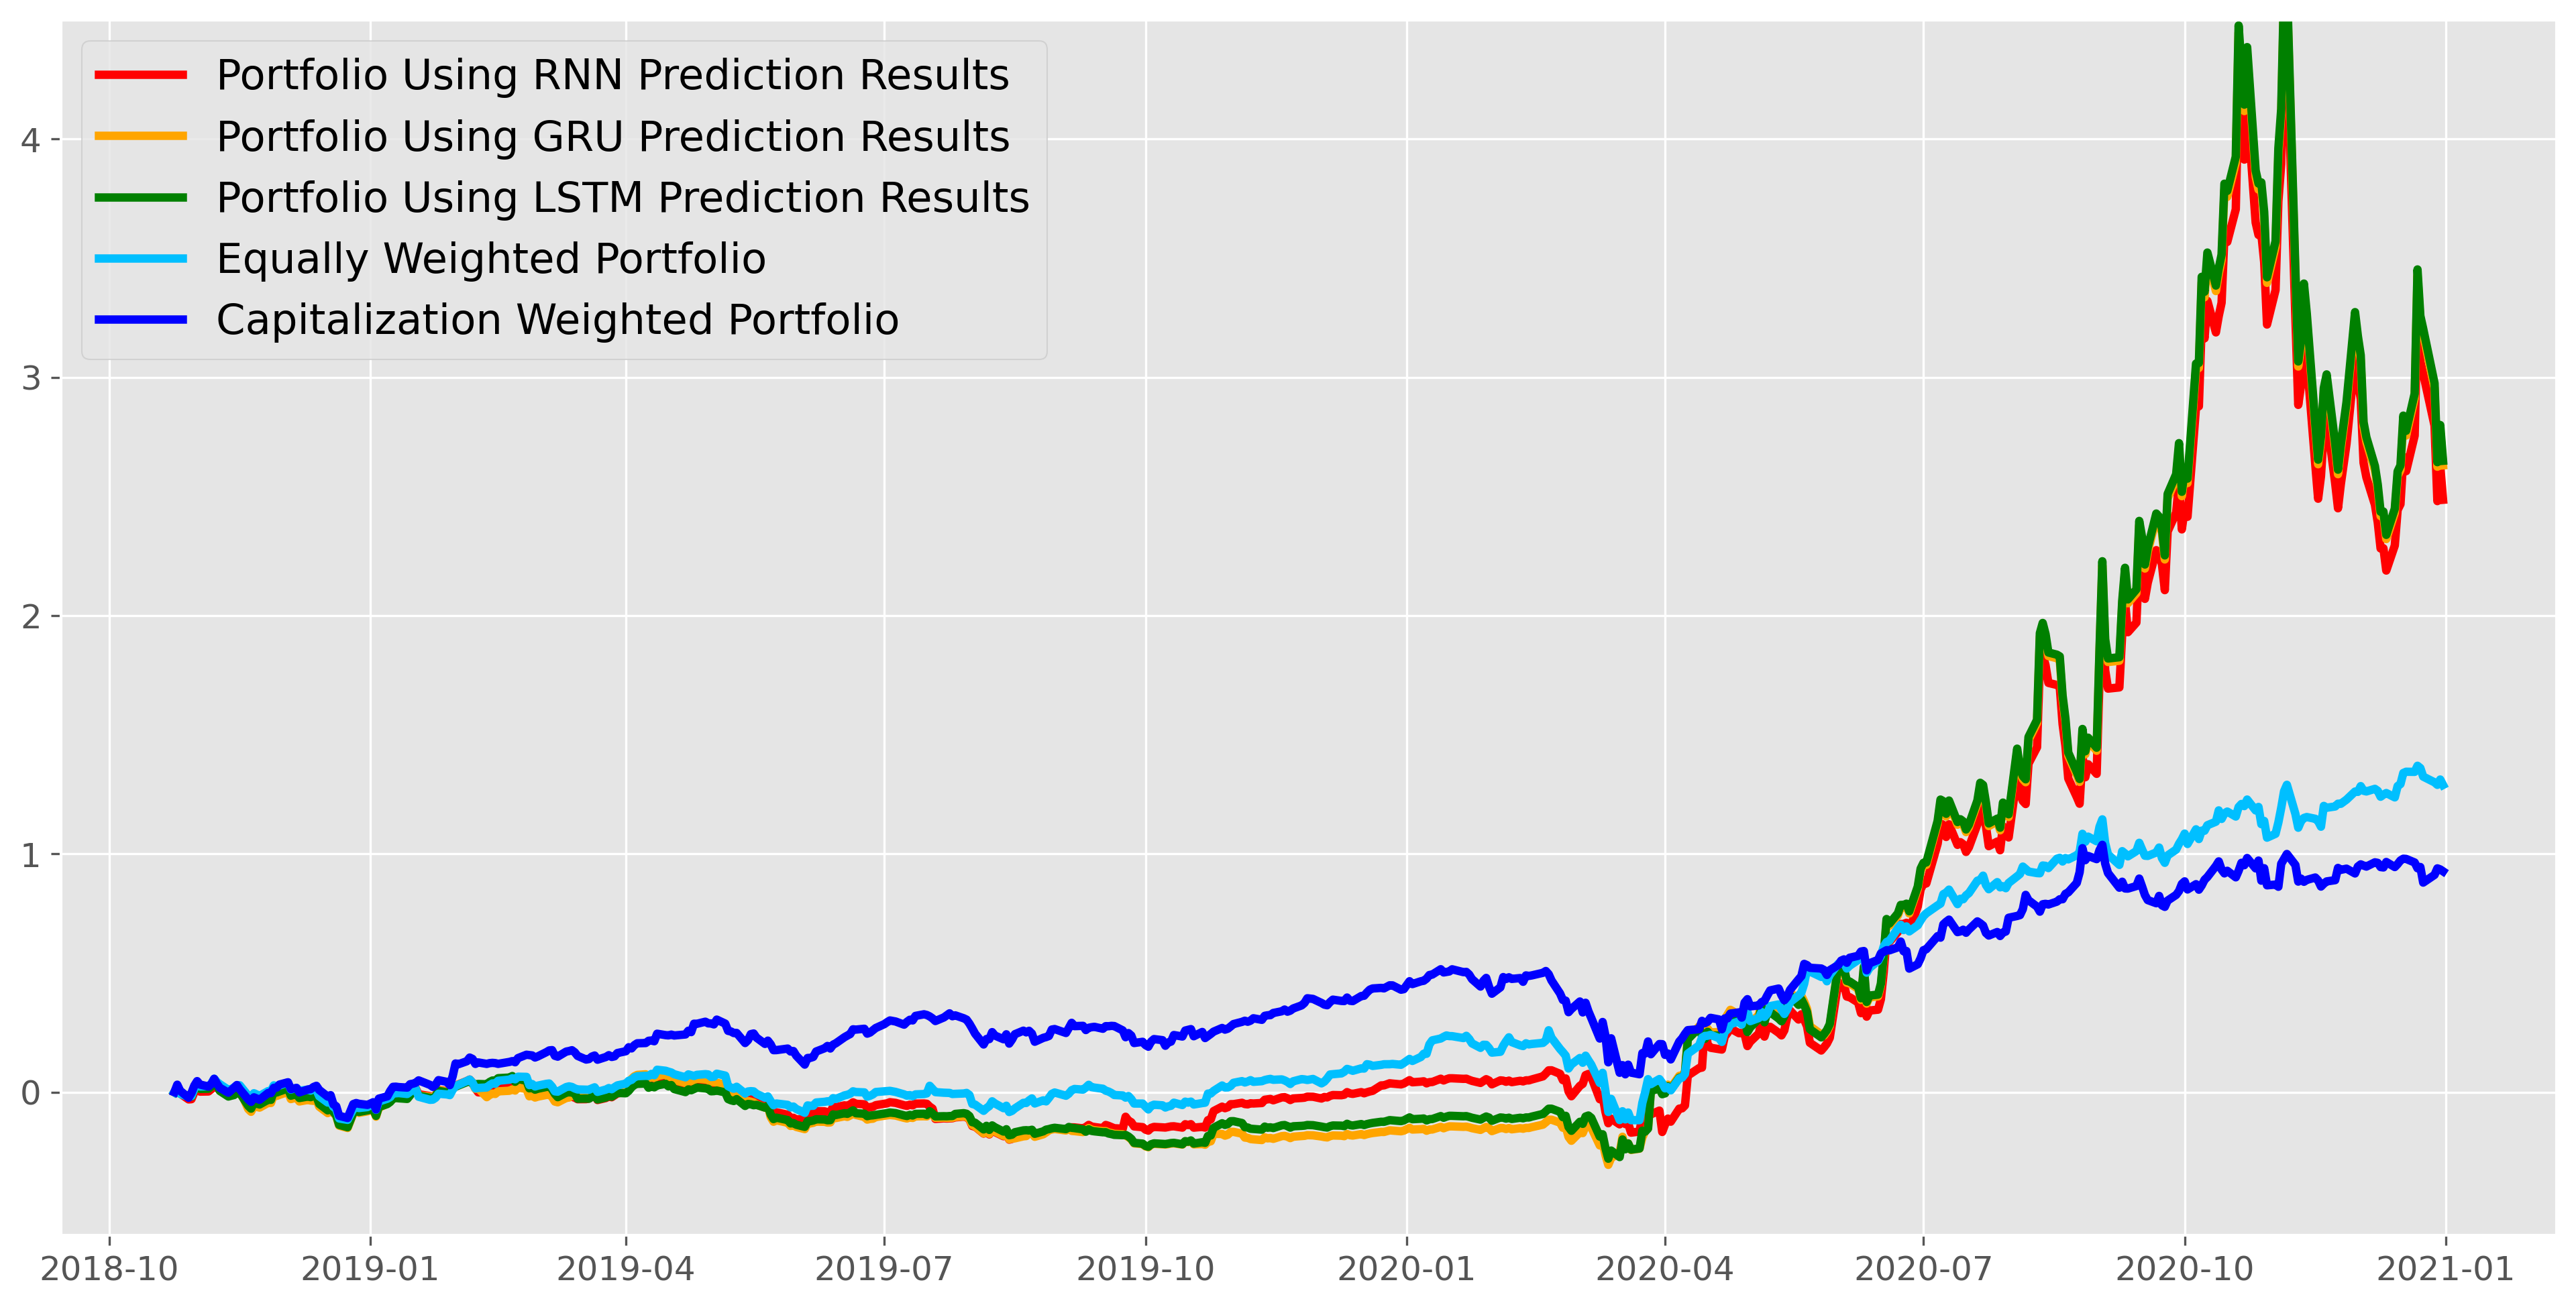

In [36]:
colors = ['red', 'orange', 'green']
for port, exp, col in zip(portfolios_final, experiments, colors):
    plt.plot(p.index.to_pydatetime(), port['Cumulative Return'], label = 'Portfolio Using ' + exp + ' Prediction Results', color = col)
line2 = plt.plot(portfolio_eqw_final.index.to_pydatetime(), portfolio_eqw_final['Cumulative Return'], label = 'Equally Weighted Portfolio', color = 'deepskyblue')
line3 = plt.plot(portfolio_mcw_final.index.to_pydatetime(), portfolio_mcw_final['Cumulative Return'], label = 'Capitalization Weighted Portfolio', color = 'blue')
plt.xticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(-0.6, 4.5)
plt.legend(prop={'size':15})
plt.savefig('images/portfolio_multi_new.pdf', bbox_inches='tight')
plt.show()